In [1]:
import scipy.special as scis
from math import pi,exp
from math import sqrt as sq
import numpy as np
from statistics import mean

def G22(k,x,xi,beta,rho):
    r = r_(x,xi)
    return 1/(1j*4*rho) * scis.hankel2(0,k*r)/beta**2

def r_(x,xi):
    return sq((x[0]-xi[0])**2 + (x[1]-xi[1])**2)

def gam_k__n_k(x,xi,ni):
    r = r_(x,xi)
    return (x[0]-xi[0])/r * ni[0] + (x[1]-xi[1])/r * ni[1]

def T22(k,x,xi,ni):
    r = r_(x,xi)
    D = k*r * scis.hankel2(1,k*r)
    return 1j/(4*r) * D * gam_k__n_k(x,xi,ni)

def geometria(lambd):
    # valle gaussian
    long_segmento_aprox = 1/8 * lambd
    x = np.arange(-7,7,long_segmento_aprox)
    sig = 1.0;    a = 1/(sig*sq(2*pi))
    vert = [(xxx,a*exp(-(xxx**2)/(2*sig**2))) for xxx in x]

    # puntos de colocacion, vector normal
    p_col = []; norm = []
    for ii in range(len(vert)-1):
        xm = mean([vert[ii][0],vert[ii+1][0]])
        zm = mean([vert[ii][1],vert[ii+1][1]])
        p_col.append((xm,zm))
        r = r_([vert[ii][0],vert[ii][1]],[vert[ii+1][0],vert[ii+1][1]])
        v = [(vert[ii+1][0]-vert[ii][0])/r, (vert[ii+1][1]-vert[ii][1])/r]
        n = [-v[1],v[0]]
        norm.append(n)
    return vert,p_col,norm

In [2]:
f = 0.5 # Hertz
w = 2*pi*f # rad/s
beta = 0.3 # km/s
lambd = beta/f # long de onda en kilometros
k = w / beta # 1/km
rho = 0.3
mu = beta**2 * rho # 2nd Lame constant
# fuente puntual (antiplana) en
XI = (0,5)

print(f"En la frecuencia {f} Hz, \lambda = {lambd} km")

En la frecuencia 0.5 Hz, \lambda = 0.6 km


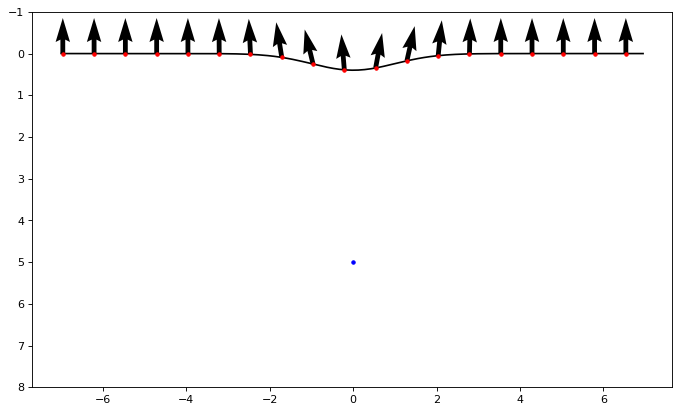

In [3]:
# la geometria
vert,p_col,norm = geometria(lambd)

from matplotlib import pyplot as plt
%matplotlib inline
fig = plt.figure(1, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k'); ax = fig.add_axes([0,0,1,1])
ax.plot([v[0] for v in vert],[v[1] for v in vert], 'k-')
# puntos de colocacion y normales a cada decimo elemento:
ax.plot([v[0] for v in p_col[0::10]],[v[1] for v in p_col[0::10]],'r.')
ax.quiver([v[0] for v in p_col[0::10]],[v[1] for v in p_col[0::10]],
          [v[0] for v in norm[0::10]],[v[1] for v in norm[0::10]])
# la fuente
ax.plot(XI[0],XI[1],'b.')
ax.set_ylim([-1, 8])
ax.invert_yaxis()
ax.set_aspect('equal')


In [4]:
def Kron(i,j):
  if i==j:
    return 1
  else:
    return 0

def Int_T22_uniforme_en_xi(i_x,i_xi,k,vert,p_col,norm):
  # i_x y i_xi son indices
  if Kron(i_x,i_xi) == 1:
    return 0

  #para cuadratura de 3 puntos
  gau_i=[-0.774597,0,0.774597] # entre -1 y 1
  w_i=[0.555556,0.888889,0.555556]

  b = vert[i_xi+1][0]
  a = vert[i_xi][0]
  xi_X_gau_i=[(b-a)/2*gau+(a+b)/2 for gau in gau_i]

  b = vert[i_xi+1][1]
  a = vert[i_xi][1]
  xi_Z_gau_i=[(b-a)/2*gau+(a+b)/2 for gau in gau_i]

  Xi_gau=[(xi_X_gau_i[i],xi_Z_gau_i[i]) for i in range(len(gau_i))]

  L = r_(vert[i_xi],vert[i_xi+1])
  # xi tiene los vertices del segmento
  Int=0+0j
  for i in range(len(gau_i)):
    Int += L/2 * w_i[i]*T22(k,p_col[i_x],Xi_gau[i],norm[i_x])
  return Int


$0.5 \delta_{ij} \phi_j(x) + \int_S \phi_j(x) T_{ij} (x,\xi) dS_\xi ) = -t_i^{(0)} (x)$

In [5]:
# para cada punto de colocacion (renglon), la integral de las fuentes sobre la superficie
Mat=np.zeros([len(p_col),len(p_col)])
Mat = Mat + 0j*Mat
print(f"A de tamaño {Mat.shape}")
for i_x in range(len(p_col)):
  for i_xi in range(len(p_col)):
    if Kron(i_x,i_xi)==1:
      Mat[i_x,i_xi]=0.5+0j
    else:
      Mat[i_x,i_xi]=Int_T22_uniforme_en_xi(i_x,i_xi,k,vert,p_col,norm)

A de tamaño (186, 186)


In [6]:
# fuente
Fue=np.zeros([len(p_col),1])
Fue = Fue + 0j*Fue
print(f"B de tamaño {Fue.shape}")
for i_x in range(len(p_col)):
  Fue[i_x]=T22(k, p_col[i_x], XI, norm[i_x])

B de tamaño (186, 1)


In [8]:
# encontrar amplitudes phi de la densidad de fuerza: phi dS
phi = np.linalg.solve(Mat,Fue)

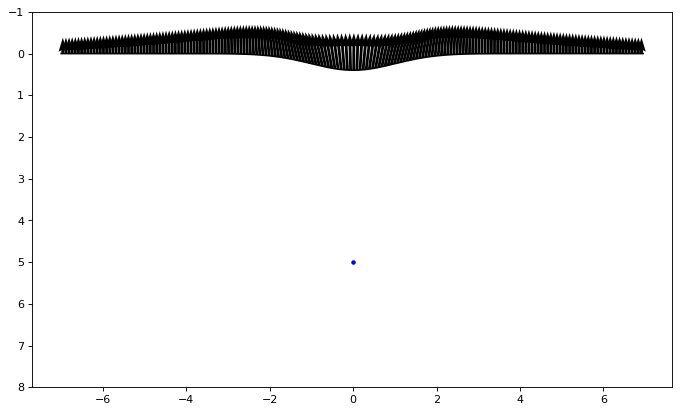

In [9]:
# graficar phi
phi_gX=[abs(phi[i]) * norm[i][0] for i in range(len(p_col))]
phi_gZ=[abs(phi[i]) * norm[i][1] for i in range(len(p_col))]

fig = plt.figure(2, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k'); ax = fig.add_axes([0,0,1,1])
ax.plot([v[0] for v in vert],[v[1] for v in vert], 'k-')

ax.quiver([v[0] for v in p_col],[v[1] for v in p_col],
          phi_gX,phi_gZ)

ax.plot(XI[0],XI[1],'b.')
ax.set_ylim([-1, 8])
ax.invert_yaxis()
ax.set_aspect('equal')

In [10]:
# ahora para construir la solucion en un observador cualquiera se hace

XX = (2,3)

V = G22(k,XX,XI,beta,rho)
for i_xi in range(len(p_col)):
  V+=G22(k,XX,p_col[i_xi],beta,rho)

print(f"En {XX}, V = {V}")

En (2, 3), V = (23.00793952678339-13.659313276884976j)
